# Transition counting

To begin estimating markov state models one needs to collect statistics over available data, in particular transitions between states at a given lag time $\tau$.

These statistics can be collected using deeptime's transition count estimator ([apidocs](../api/generated/deeptime.markov.TransitionCountEstimator.rst#deeptime.markov.TransitionCountEstimator)).

When creating an instance of said estimator, one has to make two choices: The lagtime $\tau > 0$ and the count mode. The lag time is the step size of the markov chain, i.e, an underlying transition matrix of the process with

$$  P_{ij} = \mathbb{P}(X_{t+\tau}=j \mid X_t = i). $$

The count mode can be one of:

- `"sample"`: Strides the trajectory with lagtime $\tau$ and uses the strided counts as transitions, i.e., a trajectory of length $T$ has $\lfloor T/\tau \rfloor$ counts at time indices
   $$ (0 \rightarrow \tau), (\tau \rightarrow 2 \tau), ..., (((T/ \tau )-1) \tau \rightarrow T). $$
   This means that potentially transitions can be missed.
- `"sliding"`: Uses a sliding window approach for counting. A trajectory of length $T$ has $T-\tau$ transition counts at 
   $$ (0 \rightarrow \tau), (1 \rightarrow \tau+1), ..., (T-\tau-1 \rightarrow T-1). $$
   This introduces an overestimation of the actual count values by a factor of "lagtime". For maximum-likelihood MSMs this plays no role but it leads to wrong error bars in uncertainty estimation.
- `"sliding-effective"`: Same as sliding mode, just that the resulting count matrix is divided by the lagtime after counting. This which can be shown to provide a likelihood that is the geometrical average over shifted subsamples of the trajectory, $(s_1,\:s_{tau+1},\:...),\:(s_2,\:t_{tau+2},\:...)$, etc. This geometrical average converges to the correct likelihood in the statistical limit <cite data-footcite="trendelkamp2015estimation">(Trendelkamp-Schroer, 2015)</cite>.
- `"effective"`: Uses an estimate of the transition counts that are statistically uncorrelated. Recommended when used with a [Bayesian MSM](./mlmsm.ipynb) (or the respective [API docs](../api/generated/deeptime.markov.msm.BayesianMSM.rst#deeptime.markov.msm.BayesianMSM)). A description of the estimation procedure can be found in <cite data-footcite="noe2015statistical">(Noé, 2015)</cite>.

In [1]:
import numpy as np
from deeptime.markov import TransitionCountEstimator

estimator = TransitionCountEstimator(
    lagtime=1,
    count_mode="sliding"
)

The estimator can be used to fit a count model:

In [2]:
trajectory = np.array([0, 1, 2, 3, 4, 5, 4, 3, 2, 1, 0, 1, 2, 3, 4, 5, 6, 5, 4, 3, 2, 1, 7])
counts = estimator.fit(trajectory).fetch_model()  # fit and fetch the model

The count model has several properties, which can be used to later on estimate markov state models. One of them is the count matrix $C$, which countains transition counts from one state to the other as encountered in the trajectory:

In [3]:
counts.count_matrix

array([[0., 2., 0., 0., 0., 0., 0., 0.],
       [1., 0., 2., 0., 0., 0., 0., 1.],
       [0., 2., 0., 2., 0., 0., 0., 0.],
       [0., 0., 2., 0., 2., 0., 0., 0.],
       [0., 0., 0., 2., 0., 2., 0., 0.],
       [0., 0., 0., 0., 2., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

In this example, the $(1,2)$-th element is $C_{12} = 2$, meaning there are two counted transitions from state $1$ to state $2$. Furthermore, one has access to a state histogram, which contains the information how often each state was visited within the presented data.

In [4]:
for state, histogram_value in enumerate(counts.state_histogram):
    print(f"State {state}: {histogram_value} occurances.")

State 0: 2 occurances.
State 1: 4 occurances.
State 2: 4 occurances.
State 3: 4 occurances.
State 4: 4 occurances.
State 5: 3 occurances.
State 6: 1 occurances.
State 7: 1 occurances.


## Selecting a submodel

Depending on what kind of markov model is estimated, it is required to have either a strongly or weakly connected set of states. This means that the count matrix is interpreted as an adjacency matrix
$$ A_{ij} = \begin{cases}1 &\text{, if } C_{ij} > 0 \\ 0 &\text{, otherwise.}\end{cases} $$
A graph induced by the adjacency matrix is called strongly connected if the edges are directed and there is a path from each state $i$ to each state $j$. It is called weakly connected if the edges are undirected and there is a path from each state $i$ to each state $j$.

Plotting the graph (using [networkx](https://networkx.github.io/)), one can see that our example data consists of $8$ states in total where all except state $7$ are strongly connected.

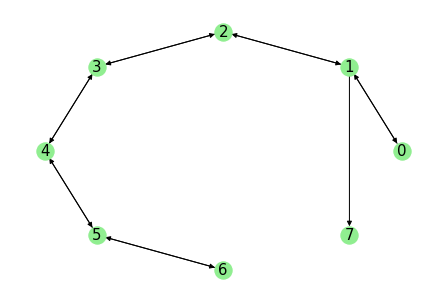

In [5]:
import matplotlib.pyplot as plt
import networkx as nx

G = nx.from_numpy_matrix(counts.count_matrix, create_using=nx.DiGraph())
pos = nx.circular_layout(G)
nx.draw_circular(G, node_color='#90EE90')
nx.draw_networkx_labels(G, pos, labels={i: i for i in G.nodes()}, font_size=15)
plt.show()

The connected sets (weak and strong) can be obtained from the model directly:

In [6]:
print("Weakly connected sets:", counts.connected_sets(directed=False))
print("Strongly connected sets:", counts.connected_sets(directed=True))

Weakly connected sets: [array([0, 1, 2, 3, 4, 5, 6, 7])]
Strongly connected sets: [array([0, 1, 2, 3, 4, 5, 6]), array([7])]


And a submodel can be selected based on either an explicitly selected subset of states:

In [7]:
submodel_explicit = counts.submodel(states=[0, 1, 7])

Which then contains a subselected count matrix. The "states" of a count model always refer to the dimensions of the count matrix, i.e., if $C\in\mathbb{R}^{n\times n}$, then there are $n$ states. To be able to trace back, which state in a submodel belongs to which state in the data, there are also "symbols", which are the states of the root model:

In [8]:
print("# states:", submodel_explicit.n_states)
print("symbols:", submodel_explicit.state_symbols)

# states: 3
symbols: [0 1 7]


If presented with a set of symbols which should be mapped to states, there is a convenience function (no longer present symbols are discarded):

In [9]:
submodel_explicit.symbols_to_states([0, 1, 7, 8])

array([0, 1, 2])

Furthermore one can restrict data to the state selection of the model. No longer present symbols are set to `-1`:

In [10]:
submodel_explicit.transform_discrete_trajectories_to_submodel(trajectory)

[array([ 0,  1, -1, -1, -1, -1, -1, -1, -1,  1,  0,  1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1,  1,  2], dtype=int32)]

Most of the time the state selection should be based on the connected sets. For this, one can call

In [11]:
submodel = counts.submodel_largest(connectivity_threshold=1., directed=True)

This selects the largest (strongly) connected set where only states with at least `1` transition count are considered connected.

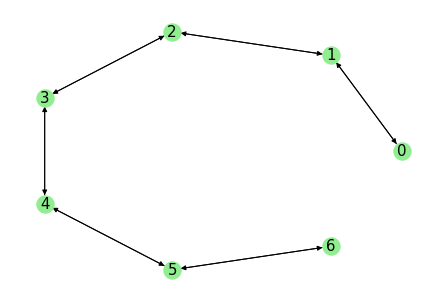

In [12]:
G = nx.from_numpy_matrix(submodel.count_matrix, create_using=nx.DiGraph())
pos = nx.circular_layout(G)
nx.draw_circular(G, node_color='#90EE90')
nx.draw_networkx_labels(G, pos, labels={i: i for i in G.nodes()}, font_size=15)
plt.show()

As one can see, the weakly connected state `7` is removed.

Optionally, one can give probability constraints of states as well as selected the connected set by population and not by size. A description of this can be found [here](../api/generated/deeptime.markov.TransitionCountModel.rst#deeptime.markov.TransitionCountModel.submodel_largest).